In [6]:
import os
import sys
import time
import tqdm
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
matplotlib.rcParams['figure.max_open_warning'] = 40
sns.set_style('whitegrid')

Сгенерируем выборку для обучения на ней градиентного бустинга

In [142]:
np.random.seed(14)
X = np.zeros((0, 2))

tmp = np.random.multivariate_normal(mean=[1, 1], cov=np.array([
    [5, 3],
    [3, 5]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[20, 20], cov=np.array([
    [1, 10],
    [10, 1]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[35, -30], cov=np.array([
    [10, 8],
    [8, 10]
]), size=40)

X = np.vstack((
    X, tmp
))

tmp = np.random.multivariate_normal(mean=[50, 20], cov=np.array([
    [1, 0],
    [0, 1]
]), size=40)

X = np.vstack((
    X, tmp
))

x_dom = np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 200)

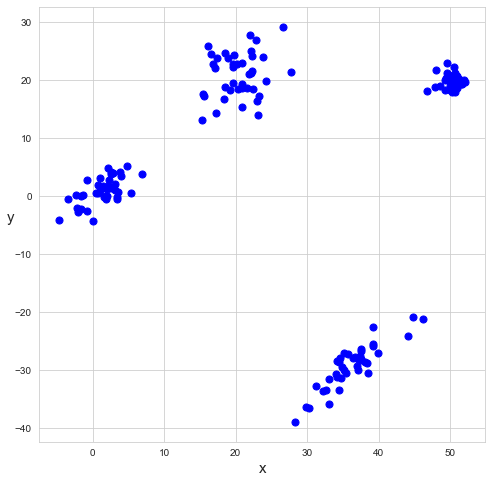

In [89]:
plt.scatter(X[:, 0], X[:, 1], color='blue', s=50);
plt.xlabel('x', fontsize=15);
plt.ylabel('y', fontsize=15, rotation=0);

#### Бустинг

$a_{N}(x) = \sum\limits_{j=1}^N b_{j}(x), \ b_{N} = arg\min\limits_{b_{N}} \frac{1}{n}\sum\limits_{i=1}^nL(y, a_{N-1}(x_{i}) + b_{N}(x_{i}))$

Пусть $L(y, z) = (y - z)^2, $ а базовые алгоритмы $(b_{j}(x))$ возьмём в классе линейных регрессий

In [90]:
models_dict = {} # в этот словарь будем сохранять модели

##### 0 шаг

$a_{N}(x) = b_{0}(x)$

$b_{0}(x) = \bar y$

In [91]:
models_dict['b_0'] = {'split': X[:, 0].min()-1, 'y_left': -1, 'y_right': X[:, 1].mean()}


In [92]:
predictions_0 = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] else models_dict['b_0']['y_right']  
                          for x in X[:, 0]])
prediction_0_for_picture = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] else models_dict['b_0']['y_right']  
                          for x in x_dom])
s_1 = X[:, 1] - predictions_0

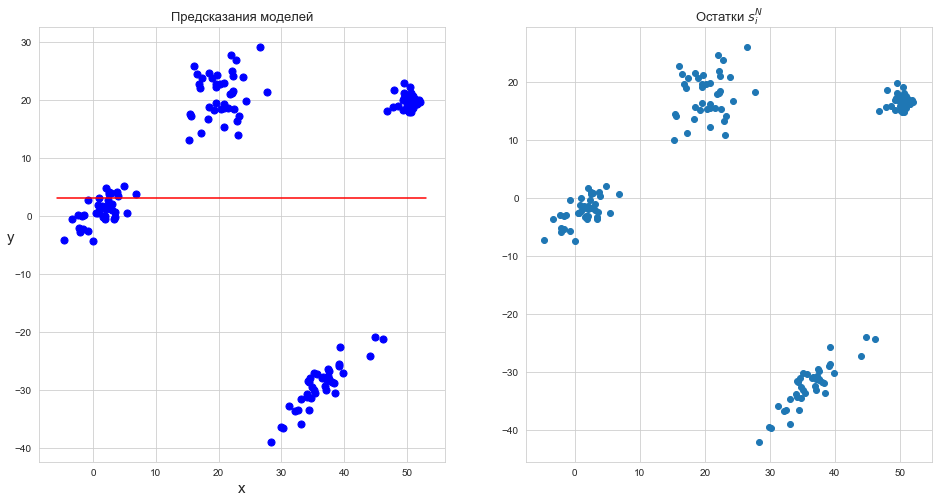

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, prediction_0_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_1);

##### 1 шаг

$a_{N}(x) = b_{0}(x) + b_{1}(x) \Rightarrow a_{N-1}(x) = b_{0}(x)$

$b_{1}(x) = arg\min\limits_{b_{1}} \frac{1}{n} \sum\limits_{i=1}^n (\underbrace{y_{i} - a_{N-1}(x_{i})}_{s_{i}^(1)} - b_{1}(x_{i}))^2 \Rightarrow b_{1}(x) = arg\min \frac{1}{n} \sum\limits_{i=1}^n (b_{1}(x_{i}) - s_{i}^{(1)})^2$ 

Но $b_{1}(x)$ - это алгоритм из определённого класса - из класса решающих пней, а значит:

$b_{1}(x) = arg\min\limits_{t, y_{left}, y_{right}} \frac{1}{n}\sum\limits_{i=1}^n ( y_{left} \cdot [x_{i} < t] + y_{right} \cdot [x_{i} \ge t]  - s_{i}^{(1)} )^2$

In [94]:
def variance_criterion(split: float, y: np.array, x: np.array) -> float:
    """
    Args:
        split: вещественное число по которому проводить разбиение на левый и правый листья
        y: значения переменной, для которой проводить разбиение
        x: значения переменной, по которой проводить разбиения
    Return:
        Взвешенное значение дисперсии в подлистьях
    """
    y_left = y[x < split]
    y_right = y[x >= split]
    
    return (len(y_left)/len(y))*y_left.var() + (len(y_right)/len(y))*y_right.var()
    

def split_leaf(x: np.array, y: np.array) -> float:
    """
    Args:
        x: признак, по которому необходимо найти оптимальное разбиение
        y: таргет, на основе которого искать оптимальное разбиение
    Return:
                                                       [x < t]
        1) оптимальное значение t разбиения листа      /     \
                                                     ...     ...
        2) оптимальное значение в левом дочернем листе
        3) оптимальное значение в правод дочернем листе
    """

    unq_split_values = sorted(list(set(x)))
    unq_split_values = np.array([(i + j)/2 for i, j in zip(unq_split_values, unq_split_values[1:])])
    best_split = None
    best_variance = None
    for split in unq_split_values:
        current_variance = variance_criterion(split=split, y=y, x=x)
        if best_split is None:
            best_variance = current_variance
            best_split = split
        else:
            if current_variance < best_variance:
                best_split = split
                best_variance = current_variance
    y_left = y[x < best_split].mean()
    y_right = y[x >= best_split].mean()
    return best_split, y_left, y_right


In [95]:
# Находим оптимальный пень b1
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_1)
print(t, y_l, y_r)

46.512474702383265 -5.588702106722146 16.766106320166433


Отсюда получаем, что $b_{1}(x) = 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] $

In [98]:
# Добавляем его в a_N(x)
models_dict['b_1'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

In [99]:
predictions_1 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_2 = X[:, 1] - predictions_1

predictions_1_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)


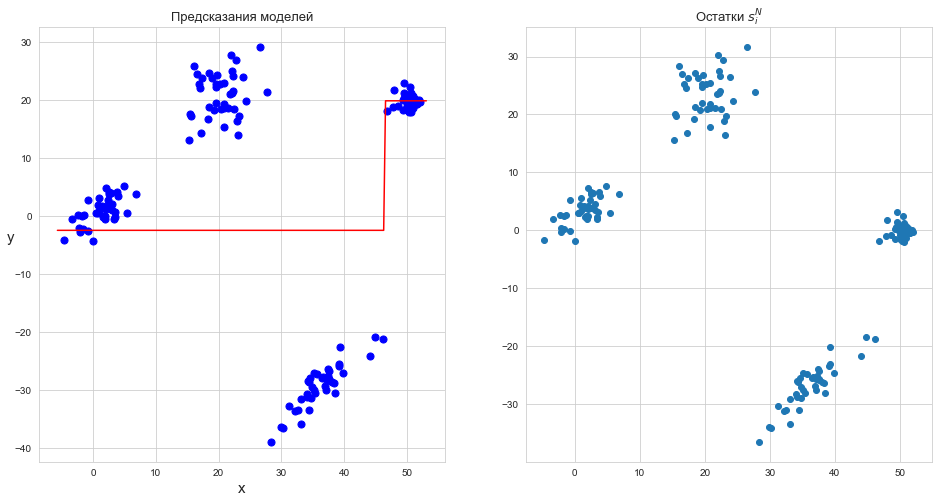

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_1_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_2);

##### 2 шаг

In [101]:
# Находим оптимальный пень b2
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_2)
print(t, y_l, y_r)

28.058999617998005 13.412145822226284 -13.412145822226282


In [102]:
# Добавляем его в a_N(x)
models_dict['b_2'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

$b_{2}(x) = 12.3 \cdot [x < 28.06] - 12.52 \cdot [x \ge 28.06] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) + b_{2}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] + 13.41 \cdot [x < 28.06] - 13.41 \cdot [x \ge 28.06] $

In [103]:
predictions_2 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_3 = X[:, 1] - predictions_2

predictions_2_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)

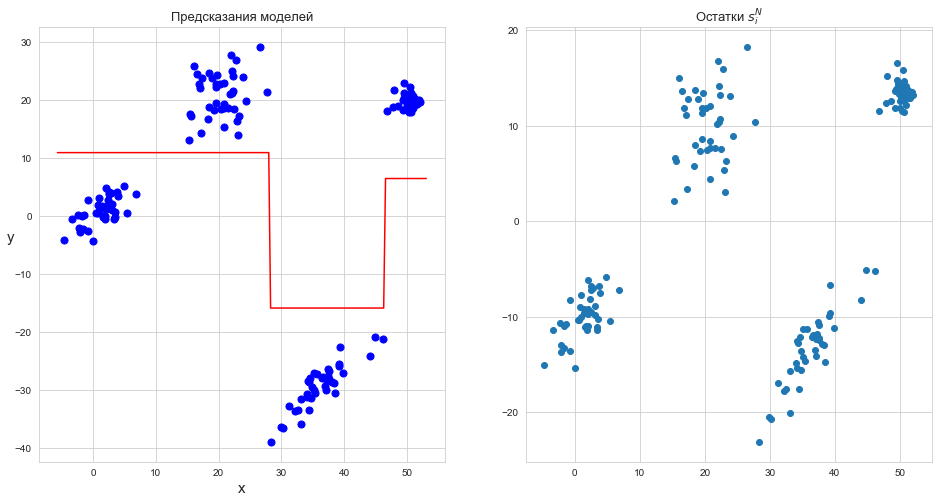

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_2_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_3);

##### 3 шаг

In [105]:
# Находим оптимальный пень b3
t, y_l, y_r = split_leaf(x=X[:, 0], y=s_3)
print(t, y_l, y_r)

46.512474702383265 -4.4707152740754275 13.412145822226284


In [106]:
# Добавляем его в a_N(x)
models_dict['b_3'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

$b_{3}(x) = 13.41 \cdot [x \ge 46.51] - 4.47 \cdot [x < 46.51] $

$a_{N}(x) = b_{0}(x) + b_{1}(x) + b_{2}(x) + b_{3}(x) = 3.15 + 16.77 \cdot [x \ge 46.51] - 5.59 \cdot [x < 46.51] + 13.41 \cdot [x < 28.06] - 13.41 \cdot [x \ge 28.06] + 13.41 \cdot [x \ge 46.51] - 4.47 \cdot [x < 46.51]$

In [108]:
predictions_3 = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in X[:, 0]]
)

s_4 = X[:, 1] - predictions_3

predictions_3_for_picture = np.array(
    [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] else models_dict[f'b_{j}']['y_right'] 
          for j in range(len(models_dict))]) for x in x_dom]
)

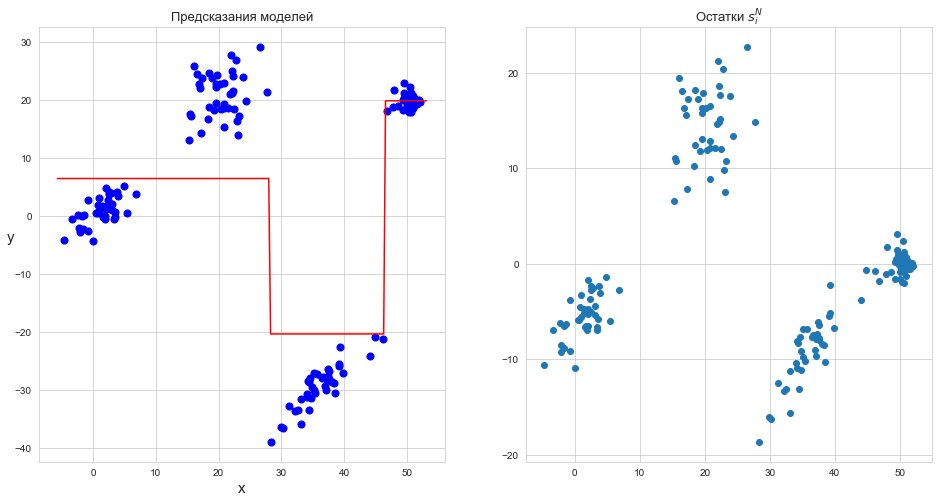

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_3_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(r'Остатки $s_{i}^{N}$', fontsize=13);
ax[1].scatter(X[:, 0], s_4);

##### Итоговый прогноз для различной длины (N) композиции

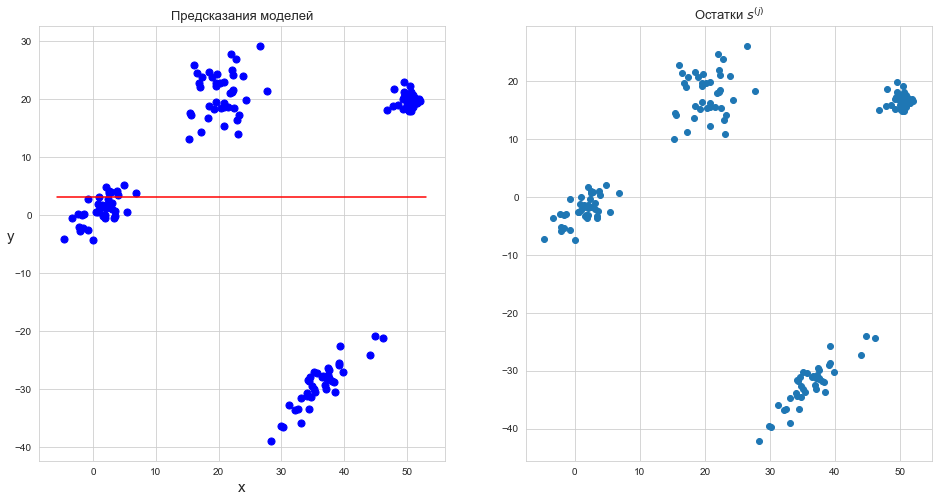

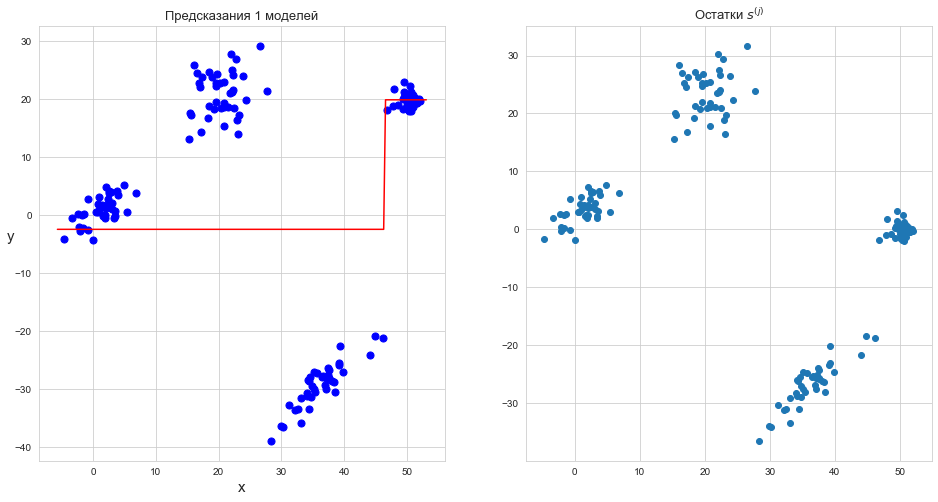

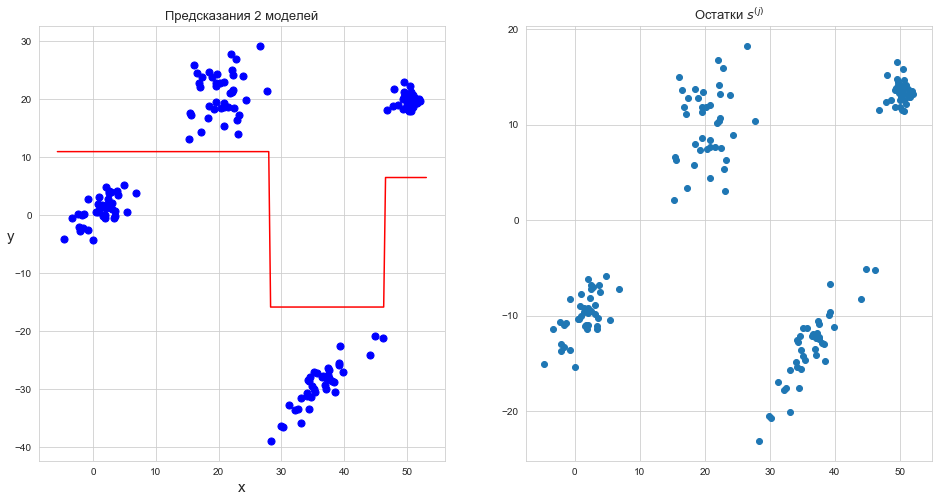

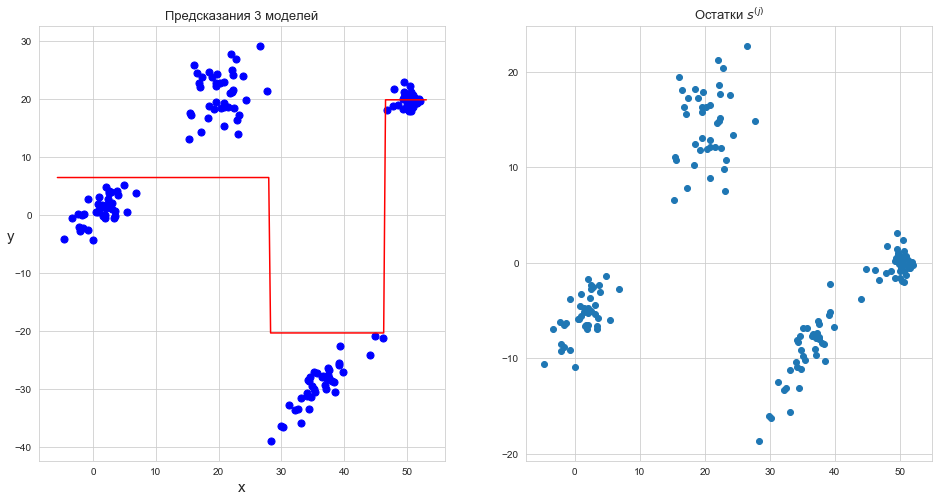

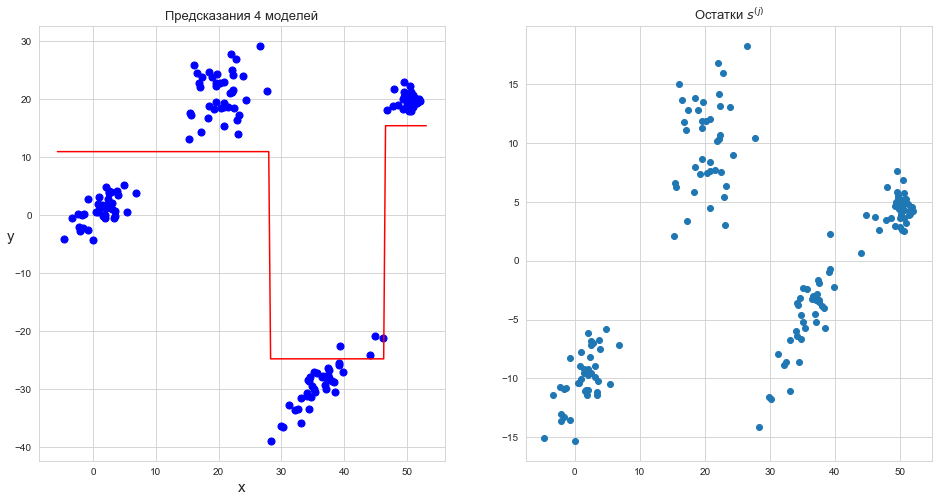

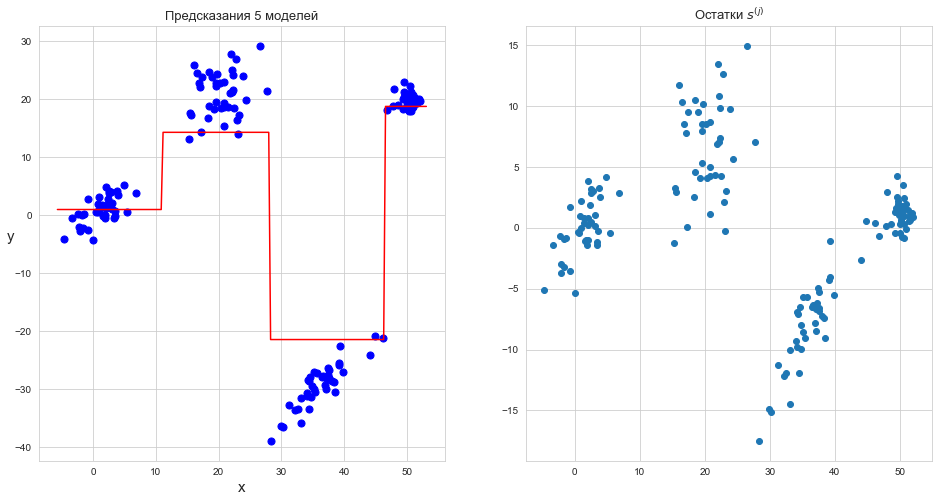

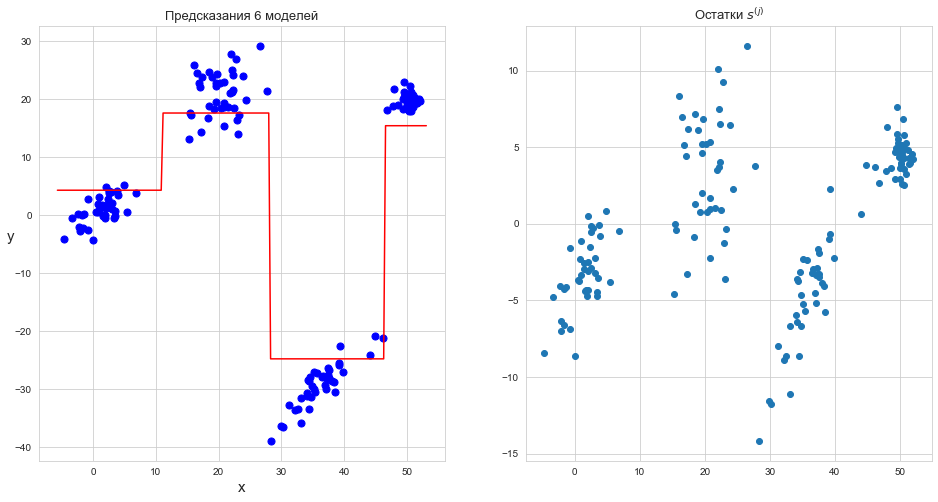

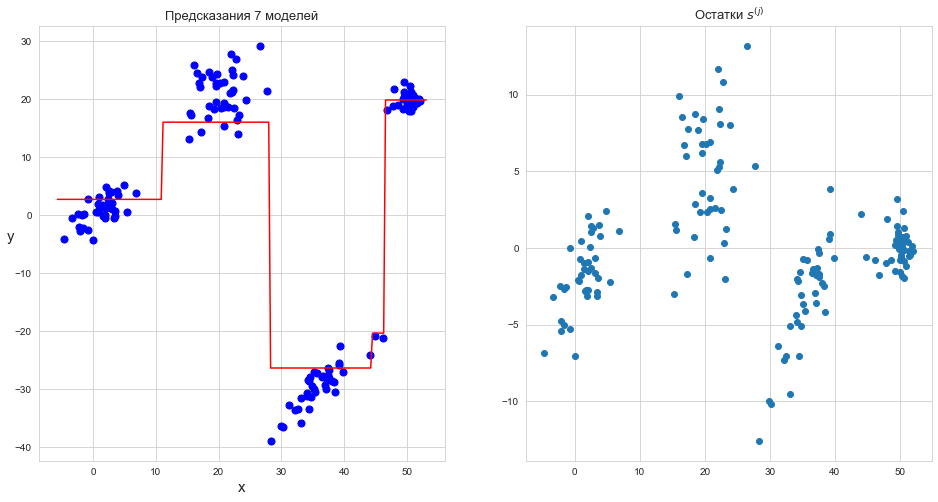

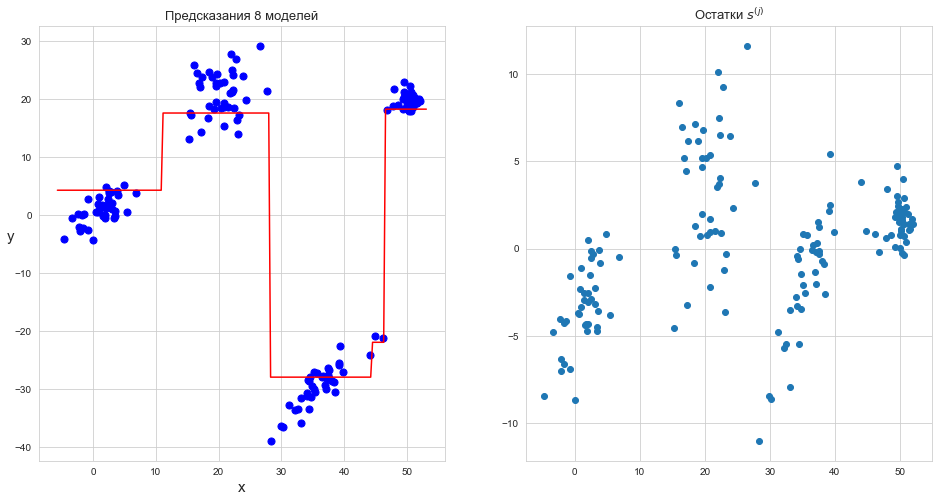

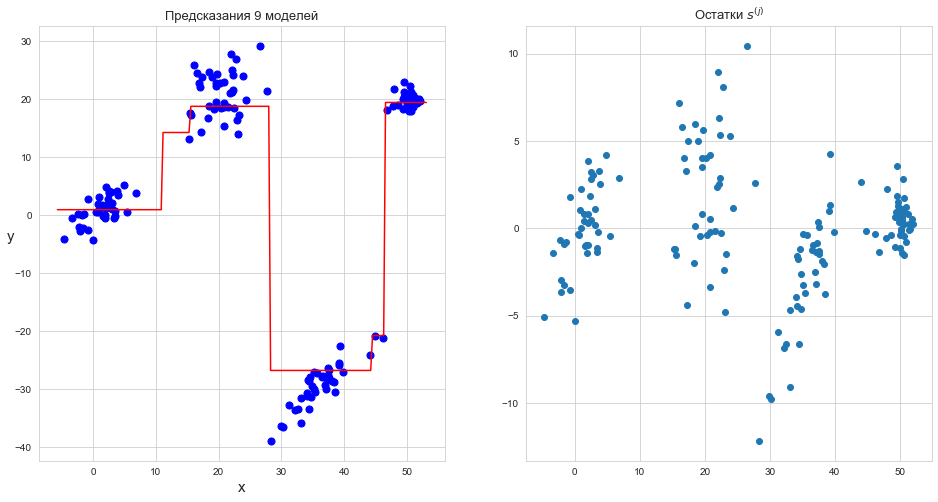

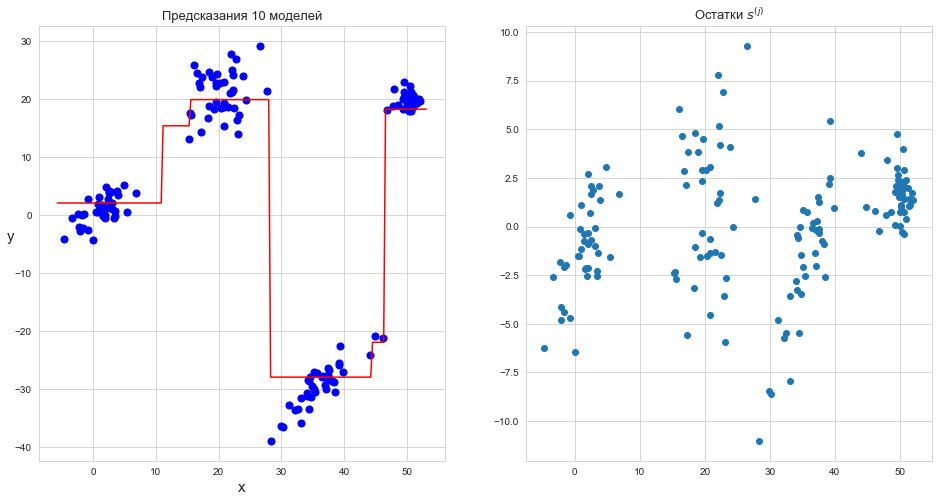

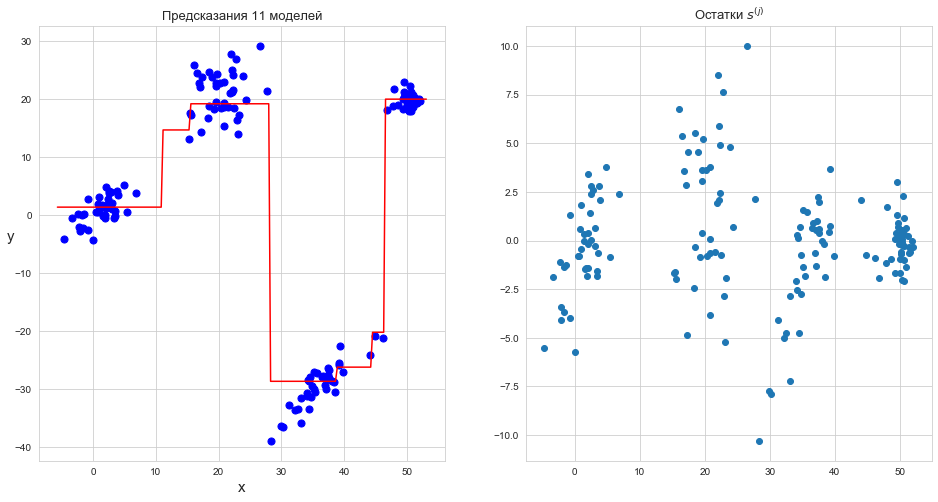

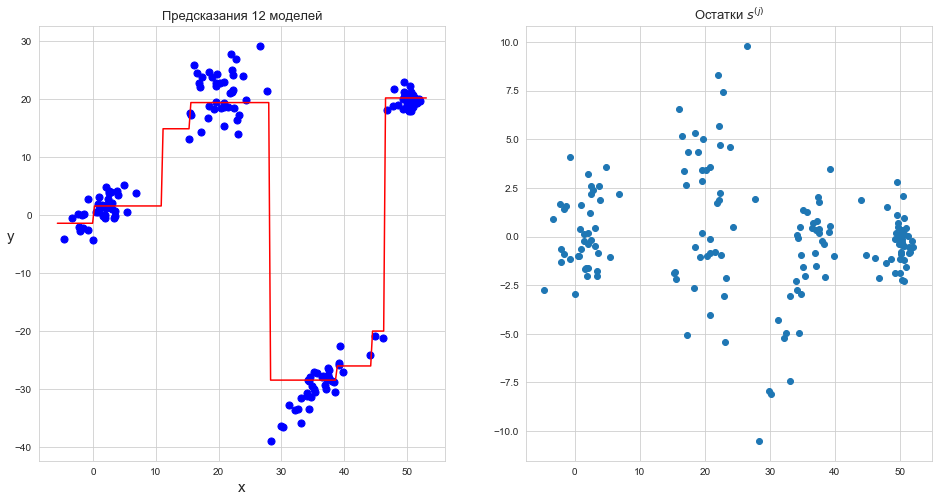

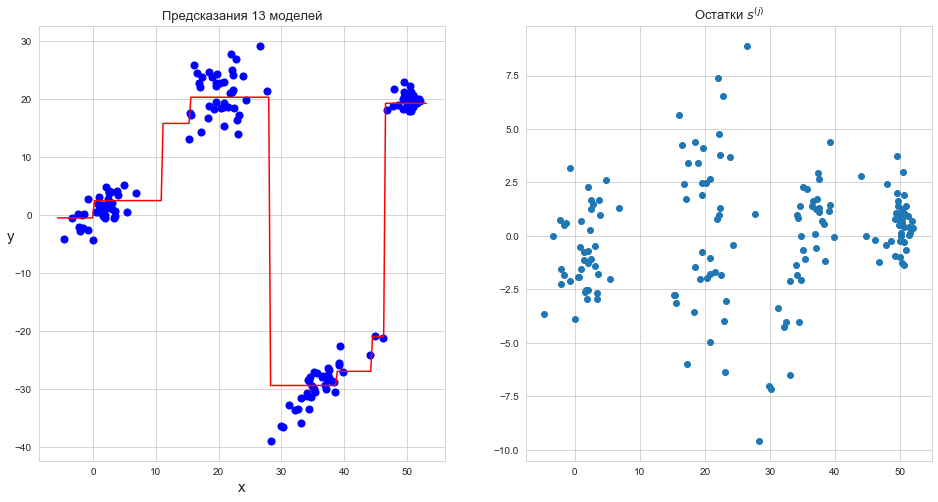

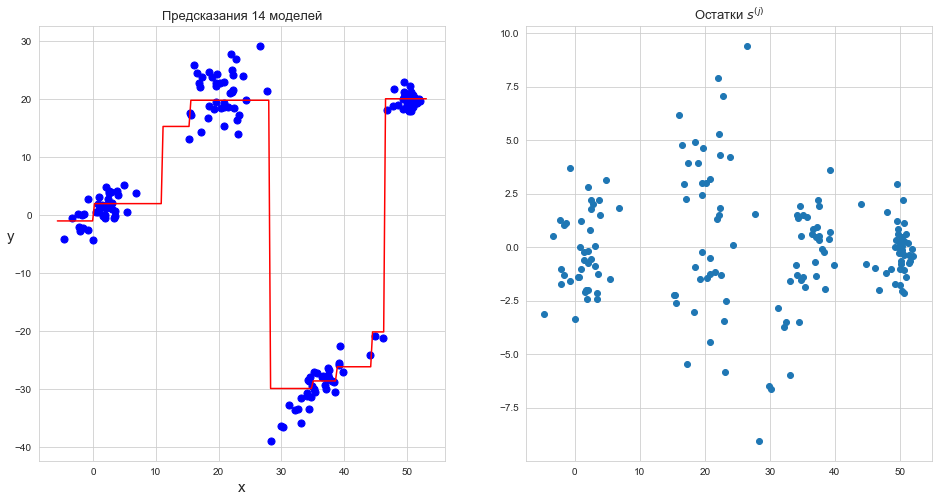

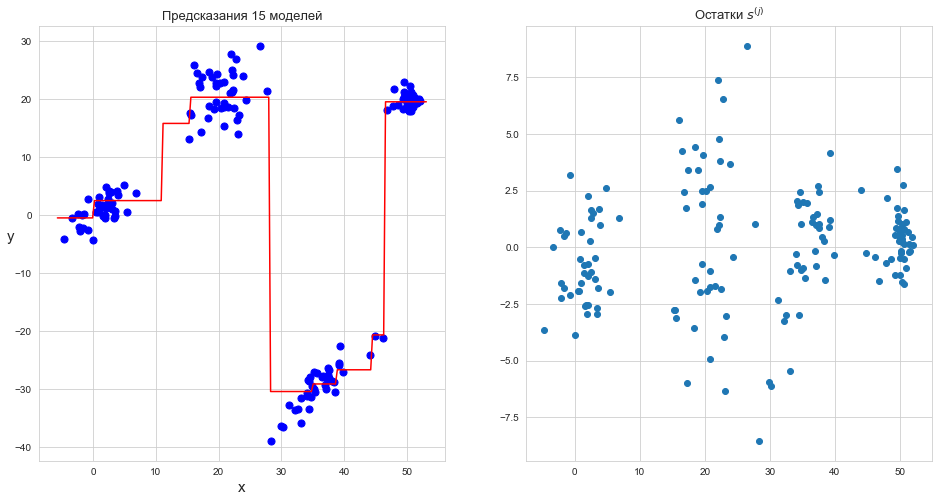

In [134]:
N = 15
models_dict = {}
hist_residuals = []
models_dict['b_0'] = {'split': X[:, 0].min()-1, 'y_left': -1, 'y_right': X[:, 1].mean()}

predictions = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] 
                        else models_dict['b_0']['y_right']  
                          for x in X[:, 0]])
predictions_for_picture = np.array([models_dict['b_0']['y_left'] if x < models_dict['b_0']['split'] 
                                    else models_dict['b_0']['y_right']  
                          for x in x_dom])
s_j = X[:, 1] - predictions
hist_residuals.append((s_j**2).sum())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].set_title('Предсказания моделей', fontsize=13)
ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
ax[0].plot(x_dom, predictions_for_picture, color='red')
ax[0].set_xlabel('x', fontsize=15);
ax[0].set_ylabel('y', fontsize=15, rotation=0);

ax[1].set_title(f'Остатки $s^{{(j)}}$', fontsize=13);
ax[1].scatter(X[:, 0], s_j);

for j in range(1, N+1):
    # Находим оптимальный пень bj
    t, y_l, y_r = split_leaf(x=X[:, 0], y=s_j)
    
    # Добавляем его в a_N(x)
    models_dict[f'b_{j}'] = {'split': t, 'y_left': y_l, 'y_right': y_r}

    predictions = np.array(
        [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] 
              else models_dict[f'b_{j}']['y_right'] 
              for j in range(len(models_dict))]) for x in X[:, 0]]
    )

    s_j = X[:, 1] - predictions
    hist_residuals.append((s_j**2).sum())

    predictions_for_picture = np.array(
        [sum([models_dict[f'b_{j}']['y_left'] if x < models_dict[f'b_{j}']['split'] 
              else models_dict[f'b_{j}']['y_right'] 
              for j in range(len(models_dict))]) for x in x_dom]
    )

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].set_title(f'Предсказания {j} моделей', fontsize=13)
    ax[0].scatter(X[:, 0], X[:, 1], color='blue', s=50);
    ax[0].plot(x_dom, predictions_for_picture, color='red')
    ax[0].set_xlabel('x', fontsize=15);
    ax[0].set_ylabel('y', fontsize=15, rotation=0);

    ax[1].set_title(f'Остатки $s^{{(j)}}$', fontsize=13);
    ax[1].scatter(X[:, 0], s_j);
    

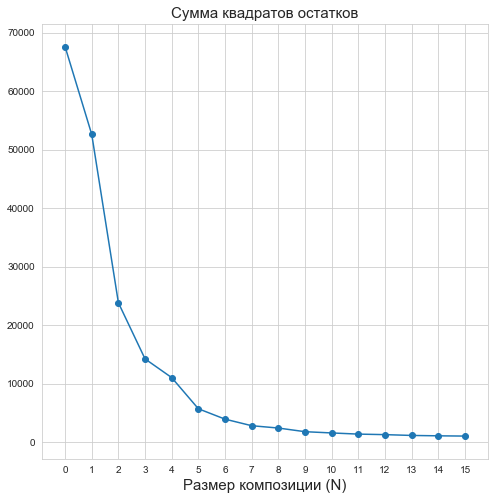

In [141]:
plt.title('Сумма квадратов остатков', fontsize=15);
plt.plot(hist_residuals);
plt.scatter(np.arange(len(hist_residuals)), hist_residuals);
plt.xlabel(f'Размер композиции (N)', fontsize=15)
plt.xticks(np.arange(N+1), np.arange(N+1));